In [63]:
# handling colab problem
import os
if not 'data' in os.listdir('..'):
    print('needs data folder. imports through git')
    !git clone https://github.com/JakartaLaw/speciale.git
    print(os.listdir())
    os.chdir('speciale//src')

In [64]:
from environments import EnvironmentModel1 as Environment
from environments import translate_action_model1 as translate_action
from environments import reward_scaler_model1 as reward_scaler
from environments import STATES_MU1, STATES_SIGMA1
from environments.model1 import scale_states

In [65]:
import pandas as pd
import matplotlib.pyplot as plt


In [66]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pickle

class MemoryBuffer():
    
    def __init__(self, action_size, state_size, mem_size=1500000, batch_size=50000):
        self.mem_size = mem_size
        self.mem_cntr = 0
        self.batch_size = batch_size
        self.action_size = action_size
        self.state_size =state_size
        
        
        self.state_memory = np.zeros((self.mem_size, state_size))
        self.q_memory = np.zeros((self.mem_size, action_size))
        
    def store_transition(self, state, q_values):
        index = self.mem_cntr % self.mem_size
        
        self.state_memory[index] = state
        self.q_memory[index] = q_values
        
        self.mem_cntr += 1
        
    def sample_batch(self):
        max_mem = min(self.mem_cntr, self.mem_size)
        _batch_size = min(self.mem_cntr, self.batch_size)
        batch = np.random.choice(max_mem, _batch_size)

        states = self.state_memory[batch]
        q_values = self.q_memory[batch]
        
        return states, q_values

    
class ArrayScaler():
    
    def __init__(self, as_scalar=False):
        
        """as_scalar=True implies that each row is scaled the same way"""
        self.as_scalar = as_scalar
        self.mu = None
        self.sigma = None
    
    def fit(self, array):
        
        if self.as_scalar is False:
            self.mu = self.calc_means(array)
            self.sigma = self.calc_stds(array)
        else:
            self.mu = np.mean(array)
            self.sigma = np.std(array)
    
    def transform(self, array):
        return (array - self.mu) / self.sigma
    
    def inverse_transform(self, array):
        return (array * self.sigma ) + self.mu

    @staticmethod
    def calc_means(array):
        return np.mean(array, axis=0)
    
    @staticmethod
    def calc_stds(array):
        states_std_ = np.std(array, axis=0)
        
        for ix, val in enumerate(states_std_):
            if val == 0.0:
                states_std_[ix] = 1.0

        return states_std_
    
class QFunctionScaler():

    def __init__(self):
        self.q_mean = None
        self.q_std = None

    def fit(self, q_vals):
        self.q_mean = np.mean(q_vals, axis=0)
        self.q_std = np.std(q_vals, axis=0)

    def transform(self, q_vals):
        q_vals_ = (q_vals - self.q_mean ) /self.q_std
        return q_vals_

    def inverse_transform(self, q_vals):
        q_vals_ = (q_vals * self.q_std ) + self.q_mean
        return q_vals_

def build_network(input_dims, output_dims, fc1_size, fc2_size, lr):
    model = Sequential()
    model.add(Dense(fc1_size, activation='relu', input_dim=input_dims))
    model.add(Dense(fc2_size, activation='relu'))
    model.add(Dense(output_dims, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(lr=lr))
    return model

class Agent():

    def __init__(self, alpha, gamma, layer1_size, layer2_size, statespace_dims, action_dims):
        self.lr = alpha
        self.gamma = gamma
        self.fc1_size = layer1_size
        self.fc2_size = layer2_size
        self.statespace_dims = statespace_dims
        self.action_dims = action_dims
        self.q_network = build_network(self.statespace_dims, self.action_dims, 
                                       self.fc1_size, self.fc2_size, self.lr) 
        
        self.memory_buffer = MemoryBuffer(action_dims, statespace_dims)
        self.q_scaler = ArrayScaler(as_scalar=True)
        self.state_scaler = ArrayScaler()
        self.state_scaler.mu = STATES_MU1
        self.state_scaler.sigma = STATES_SIGMA1
        
    def save_model(self, name='dqfi_model'):

        self.q_network.save(name + ".h5",save_format='h5')
        q_scaler_params = {'mu': self.q_scaler.mu, 'sigma': self.q_scaler.sigma}
        print(q_scaler_params)
        with open(name + '.q_scaler.pkl', 'wb') as f:
            pickle.dump(q_scaler_params, f)
    
    def load_model(self, name='dqfi_model'):
        self.q_network = load_model(name + '.h5', )
        with open(name + '.q_scaler.pkl', 'rb') as f:
            q_scaler_params = pickle.load(f)
            
        self.q_scaler.mu = q_scaler_params['mu']
        self.q_scaler.mu = q_scaler_params['sigma']
        
    def sample(self):
        states, q_vals = self.memory_buffer.sample_batch()
        self.q_scaler.fit(q_vals)
        q_vals, states = self.q_scaler.transform(q_vals), self.state_scaler.transform(states)
        return states, q_vals
    
    def learn(self, verbose=True, rebuild_network=True):

        states, q_vals = self.sample()
        
        if rebuild_network:
            print('rebuilding network')
            self.q_network = build_network(self.statespace_dims, self.action_dims, 
                                       self.fc1_size, self.fc2_size, self.lr)
        
        history_ = self.q_network.fit(states, q_vals, epochs=150, validation_split=0.3, 
                                    callbacks=[EarlyStopping(patience=5)], verbose=0)
        
        
        n_epochs = history_.epoch[-1] 
        loss_, val_loss_ = history_.history['loss'][-1], history_.history['val_loss'][-1]
        scaled_val_loss_ = np.float(np.mean(self.q_scaler.sigma) * val_loss_)
        
        if verbose:
            print(f'# epochs: {n_epochs}, loss: {loss_:.3}, val loss: {val_loss_:.3}, scaled val loss: {scaled_val_loss_:.3}')
            
    def remember(self, state, q_values):
        self.memory_buffer.store_transition(state, q_values)
        
    def act(self, state):
        state = self.state_scaler.transform(state)
        state = state[np.newaxis, :]
        q_values = self.q_network.predict(state)
        action, q_value = np.argmax(q_values), self.q_scaler.inverse_transform(q_values)
        return action, q_value
        
    def predict_q_vals(self, new_states, rewards, done):
        rewards = rewards[np.newaxis, :]
        new_states = self.state_scaler.transform(new_states)
  
        if done:
            q_vals = rewards
        else:
            q_vals_next = self.q_network.predict(new_states)
            q_vals_next = self.q_scaler.inverse_transform(q_vals_next)
            
            # the correct axis should be axis=1
            q_vals_next_star = np.max(q_vals_next, axis=1)
            #q_vals_next_star = np.max(q_vals_next, axis=0)

            q_vals = rewards + self.gamma * q_vals_next_star


        return q_vals


In [67]:
class StateSpaceSampler():
    
    def __init__(self):
    
        self.Q_min = 60
        self.Q_max = 60
        
        self.K_min = 0
        self.K_max = 5
        
        self.G_min = 0.0
        self.G_max = 5.0
        
        self.Z_min = -200.0
        self.Z_max = 200.0
        
        self.beta_K_min = 0.2
        self.beta_K_max = 6.0
        
        self.beta_L_min = 0.2
        self.beta_L_max = 6.0
        
    def draw_state(self):
        Q = np.random.randint(self.Q_min, self.Q_max + 1)
        K = np.random.randint(self.K_min, self.K_max + 1)
        G = np.random.uniform(self.G_min, self.G_max)
        Z = np.random.uniform(self.Z_min, self.Z_max)
        
        beta_K = np.random.uniform(self.beta_K_min, self.beta_K_max)
        beta_L = np.random.uniform(self.beta_L_min, self.beta_L_max)
        
        return (Q, G, K, Z, beta_L)
        
    def expand_pos_states(self):
        """creates to expand possible states"""
        self.Q_min = self.Q_min - 1
        self.Q_max = self.Q_max - 1

In [68]:
def transform_state(states):
    """helper for turning states in to parameters"""
    states_ = states[0:4]
    parameters = {
        'beta_L': states[4]
    }
    return states_, parameters

In [57]:
parameters = {
    'beta_L' : 1,
    'sigma_epsilon' : 0.1, 
    'S_min': 120.0,
    'alpha': 4.609,
    'eta_G': 0.164,
    'eta_G_sq' : 0.015,
    'delta': 0.209,
    'sigma_epsilon': 15.11,
    'omega': 3.5,
}

In [58]:
env = Environment(**parameters)

In [59]:
agent = Agent(0.005, 0.99 ,16, 8, 5, 4)
agent.load_model()
sss = StateSpaceSampler()
ACTIONS = np.array([0, 25, 37, 45])

In [60]:
agent.q_network.predict(np.array([[1.1, 2.2, 3.3, 4.5, 1.1]]))

array([[0.7220229 , 0.26687008, 0.1555842 , 0.7926965 ]], dtype=float32)

rewards_all = list()
while sss.Q_min > 24:
    print(sss.Q_min)
    for i in range(1000):

        # ugly
        _states_ = sss.draw_state()
        _states, _params = transform_state(_states_)
        scaled_state = scale_states(*_states_)

        # ugly
        rewards = np.zeros(shape=4)
        new_states = np.zeros(shape=(4, 6)) 
        for ix, action in enumerate(ACTIONS):
            env.reset(_states, _params)

            new_scaled_state, reward, done, _info = env.step(action)
            #scaled_reward = reward_scaler(reward, env.beta_K, env.beta_L)
            #rewards[ix] = scaled_reward
            rewards[ix] = reward
            new_states[ix] = new_scaled_state
        
        print(rewards)
        rewards_all.append(np.argmax(rewards))
        q_vals = agent.predict_q_vals(new_states, rewards, done)
        agent.remember(scaled_state, q_vals)

    agent.learn()
    sss.expand_pos_states()

In [61]:
rewards_all = list()
while sss.Q_min > 55:
    print("\n")
    print(f"age: {sss.Q_min}")
    try:
        print(f"q_scaler sigma: {float(agent.q_scaler.sigma):.2}, q_scaler mu: {float(agent.q_scaler.mu):.2}")
    except:
        pass

    for i in range(500):

        # ugly
        _states_ = sss.draw_state()
        _states, _params = transform_state(_states_)
        #scaled_state = scale_states(*_states_)


        # ugly
        rewards = np.zeros(shape=4)
        new_states = np.zeros(shape=(4, 5)) 
        for ix, action in enumerate(ACTIONS):
            env.reset(_states, _params)

            new_state, reward, done, _info = env.step(action)
            scaled_reward = reward_scaler(reward, env.beta_L)
            rewards[ix] = scaled_reward
            #rewards[ix] = reward
            new_states[ix] = new_state
        
        rewards_all.append(np.argmax(rewards))
        q_vals = agent.predict_q_vals(new_states, rewards, done)
        
        if i < 5:
            print(q_vals[0][0])
            
        agent.remember(_states_, q_vals)

    agent.learn()
    sss.expand_pos_states()



age: 60
-0.11558552919969085
0.3554924202039776
-0.04416449276855161
0.017499683421936158
0.15355522317219084
rebuilding network
# epochs: 67, loss: 0.0099, val loss: 0.00996, scaled val loss: 0.00119


age: 59
q_scaler sigma: 0.12, q_scaler mu: 0.049
0.8273914712529944
0.13049585655169932
0.18239541307465146
0.2772929842524784
-0.07955735633410418
rebuilding network
# epochs: 111, loss: 0.101, val loss: 0.116, scaled val loss: 0.0212


age: 58
q_scaler sigma: 0.18, q_scaler mu: 0.13
1.0411967190385998
0.021006272135844384
-0.06907832592401064
1.2017521611101312
1.0131173627452814
rebuilding network
# epochs: 89, loss: 0.0313, val loss: 0.0367, scaled val loss: 0.00889


age: 57
q_scaler sigma: 0.24, q_scaler mu: 0.2
1.2499539233098886
0.5016441395883101
0.19869220055062797
0.14723584412406865
0.1629447367152134
rebuilding network
# epochs: 46, loss: 0.0275, val loss: 0.0333, scaled val loss: 0.0104


age: 56
q_scaler sigma: 0.31, q_scaler mu: 0.27
0.5633154092405471
1.48070099100732

In [69]:
agent.save_model()

{'mu': 0.3630390895127811, 'sigma': 0.39043367483622143}


In [70]:
agent.load_model()

Resultat på måde (axis=0)

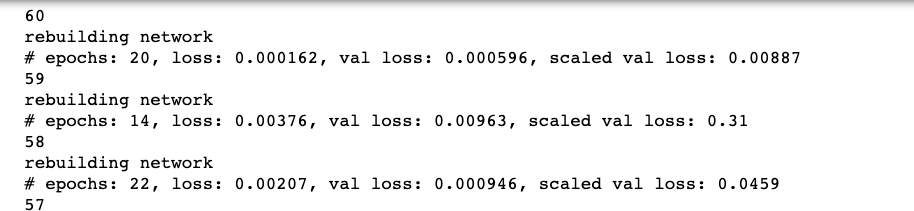

In [71]:
rewards_history, action_history = list(), list()
EPISODES = 150
agent.epsilon=0.0

agent.q_scaler.mu = 0.068
agent.q_scaler.sigma = 0.16


for e in range(EPISODES):
    env.reset()
    state = env.states
    for time in range(18, 500):
        action, q_vals = agent.act(state)
        _action = translate_action(action)
        next_state, reward, done, _ = env.step(_action)
        scaled_reward = (reward - 24 ) / 5

        
        rewards_history.append([reward, e, time])
        action_history.append([_action, e, time])
        
        state = next_state
        if done:
            #print("episode: {}/{}, score: {}, e: {:.2}".format(e, EPISODES, np.mean(rewards_history), agent.epsilon))
            break

df_DQAgent = pd.DataFrame(rewards_history, columns=['rewards', 'episode', 'Q'])
df_DQAgent_action = pd.DataFrame(action_history, columns=['actions', 'episode', 'Q'])

In [72]:
def random_action():
    act = np.random.randint(0, 4)
    return [0, 25, 37, 45][act]


In [73]:
rewards_history, action_history = list(), list()
EPISODES = 150
for e in range(EPISODES):
    env.reset()
    state = env.states
    for time in range(18, 500):
        _action = random_action()
        next_state, reward, done, _ = env.step(_action)

        
        rewards_history.append([reward, e, time])
        action_history.append([_action, e, time])
        
        state = next_state
        if done:
            break
            
df_random_agent = pd.DataFrame(rewards_history, columns=['rewards', 'episode', 'Q'])

In [74]:
rewards_history, action_history = list(), list()
EPISODES = 150
for e in range(EPISODES):
    env.reset()
    state = env.states
    for time in range(18, 500):
        _action = 0
        next_state, reward, done, _ = env.step(_action)

        
        rewards_history.append([reward, e, time])
        action_history.append([_action, e, time])
        
        state = next_state
        if done:
            break

df_0_agent = pd.DataFrame(rewards_history, columns=['rewards', 'episode', 'Q'])

In [75]:
rewards_history, action_history = list(), list()
EPISODES = 150
for e in range(EPISODES):
    env.reset()
    state = env.states
    for time in range(18, 500):
        _action = 37
        next_state, reward, done, _ = env.step(_action)

        
        rewards_history.append([reward, e, time])
        action_history.append([_action, e, time])
        
        state = next_state
        if done:
            break

df_37_agent = pd.DataFrame(rewards_history, columns=['rewards', 'episode', 'Q'])

In [76]:
rewards_history, action_history = list(), list()
EPISODES = 150
for e in range(EPISODES):
    env.reset()
    state = env.states
    for time in range(18, 500):
        _action = 45
        next_state, reward, done, _ = env.step(_action)

        
        rewards_history.append([reward, e, time])
        action_history.append([_action, e, time])
        
        state = next_state
        if done:
            break

df_45_agent = pd.DataFrame(rewards_history, columns=['rewards', 'episode', 'Q'])

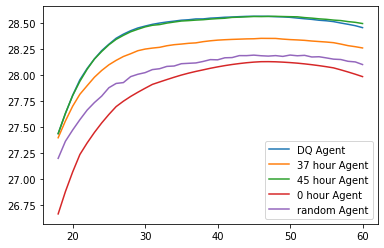

In [77]:
import matplotlib.pyplot as plt
#plt.plot(df_random_agent.drop('episode', axis=1).groupby('Q').mean(), label='Random Agent')
plt.plot(df_DQAgent.drop('episode', axis=1).groupby('Q').mean(), label='DQ Agent')
plt.plot(df_37_agent.drop('episode', axis=1).groupby('Q').mean(), label='37 hour Agent')
plt.plot(df_45_agent.drop('episode', axis=1).groupby('Q').mean(), label='45 hour Agent')
plt.plot(df_0_agent.drop('episode', axis=1).groupby('Q').mean(), label='0 hour Agent')
plt.plot(df_random_agent.drop('episode', axis=1).groupby('Q').mean(), label='random Agent')


plt.legend()

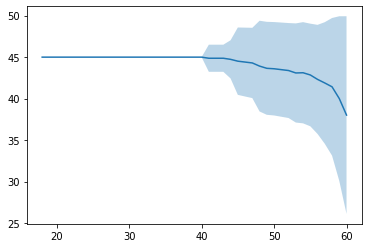

In [78]:
upper_bound = df_DQAgent_action.drop('episode', axis=1).groupby('Q').mean() \
              + df_DQAgent_action.drop('episode', axis=1).groupby('Q').std()
lower_bound = df_DQAgent_action.drop('episode', axis=1).groupby('Q').mean() \
              - df_DQAgent_action.drop('episode', axis=1).groupby('Q').std()

plt.plot(df_DQAgent_action.drop('episode', axis=1).groupby('Q').mean())
plt.fill_between(range(18,61), upper_bound['actions'], lower_bound['actions'], alpha=0.3)
